<a href="https://colab.research.google.com/github/joomj2000/OpenCV/blob/main/ViT_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 비전 트랜스포머(ViT) 모델 구현 실습

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

169001437/169001437 [==============================] - 14s 0us/step


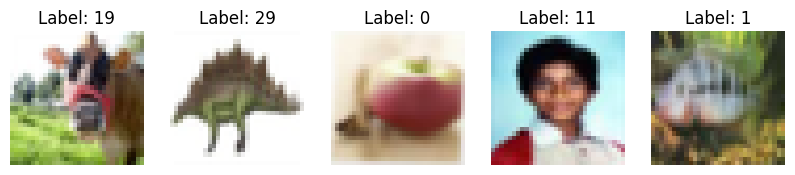

In [2]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar100.load_data()
num_classes = 100

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_x[i])
    plt.title(f"Label: {train_y[i][0]}")
    plt.axis('off')
plt.show()

In [3]:
print(f"스케일링 전 픽셀의 최대 값과 최소 값:{train_x.min()} ~ {train_x.max()}")
train_x = train_x/255.
test_x = test_x/255.
print(f"스케일링 후 픽셀의 최대 값과 최소 값:{train_x.min()} ~ {train_x.max()}")

스케일링 전 픽셀의 최대 값과 최소 값:0 ~ 255
스케일링 후 픽셀의 최대 값과 최소 값:0.0 ~ 1.0


여기까지는 구글넷과 코드가 동일합니다(cifar10 대신 cifar100 사용)

In [4]:
input_shape = (32, 32, 3)
batch_size = 64   # 트랜스포머는 대규모 병렬 처리가 용이하므로 배치 사이즈를 키워보는 것도 좋습니다.

image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2

learning_rate = 1e-3
weight_decay = 1e-4
epochs = 30

transformer_layers = 4
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
mlp_head_units = [2048, 1024]

In [5]:
class PatchTokenization(layers.Layer):
    def __init__(self, image_size=image_size, patch_size=patch_size, num_patches=num_patches, projection_dim=projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        tokens = self.projection(flat_patches)
        return (tokens, patches)

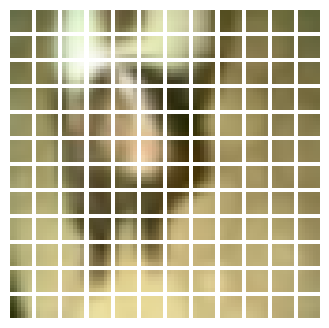

In [6]:
image = train_x[np.random.choice(range(train_x.shape[0]))]
resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(image_size, image_size))

(token, patch) = PatchTokenization()(resized_image)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (patch_size, patch_size, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()

In [7]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches=num_patches, projection_dim=projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [8]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [9]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    x = layers.Normalization()(inputs)
    x = layers.Resizing(image_size, image_size)(x)
    (tokens, _) = PatchTokenization()(x)
    encoded_patches = PatchEncoder()(tokens)
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = mlp(x, hidden_units=mlp_head_units, dropout_rate=0.5)
    outputs = layers.Dense(num_classes)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
class CosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps):
        super().__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("total_steps 값이 warmup_steps보다 크거나 같아야합니다.")

        cos_annealed_lr = tf.cos(self.pi * (tf.cast(step, tf.float32) - self.warmup_steps) / float(self.total_steps - self.warmup_steps))
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "learning_rate_base 값이 warmup_learning_rate보다 크거나 같아야합니다.")
            slope = (self.learning_rate_base - self.warmup_learning_rate) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(step < self.warmup_steps, warmup_rate, learning_rate)
        return tf.where(step > self.total_steps, 0.0, learning_rate, name="learning_rate")

In [11]:
total_steps = int((len(train_x) / batch_size) * epochs)
warmup_epoch_percentage = 0.10
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = CosineDecay(
    learning_rate_base=learning_rate,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,)

In [12]:
vit = create_vit_classifier()

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=scheduled_lrs,
    weight_decay=weight_decay)

vit.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])

In [13]:
history = vit.fit(
    x=train_x,
    y=train_y,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2)

Epoch 1/30
625/625 [==============================] - 57s 66ms/step - loss: 4.9197 - accuracy: 0.0144 - top-5-accuracy: 0.0645 - val_loss: 4.4576 - val_accuracy: 0.0296 - val_top-5-accuracy: 0.1143
Epoch 2/30
625/625 [==============================] - 40s 64ms/step - loss: 4.4363 - accuracy: 0.0281 - top-5-accuracy: 0.1235 - val_loss: 4.1953 - val_accuracy: 0.0514 - val_top-5-accuracy: 0.2063
Epoch 3/30
625/625 [==============================] - 39s 62ms/step - loss: 4.3040 - accuracy: 0.0405 - top-5-accuracy: 0.1623 - val_loss: 4.1588 - val_accuracy: 0.0529 - val_top-5-accuracy: 0.2194
Epoch 4/30
625/625 [==============================] - 41s 66ms/step - loss: 4.1260 - accuracy: 0.0593 - top-5-accuracy: 0.2187 - val_loss: 3.7743 - val_accuracy: 0.1058 - val_top-5-accuracy: 0.3325
Epoch 5/30
625/625 [==============================] - 41s 66ms/step - loss: 3.7319 - accuracy: 0.1146 - top-5-accuracy: 0.3424 - val_loss: 3.4416 - val_accuracy: 0.1704 - val_top-5-accuracy: 0.4248
Epoch 6/30

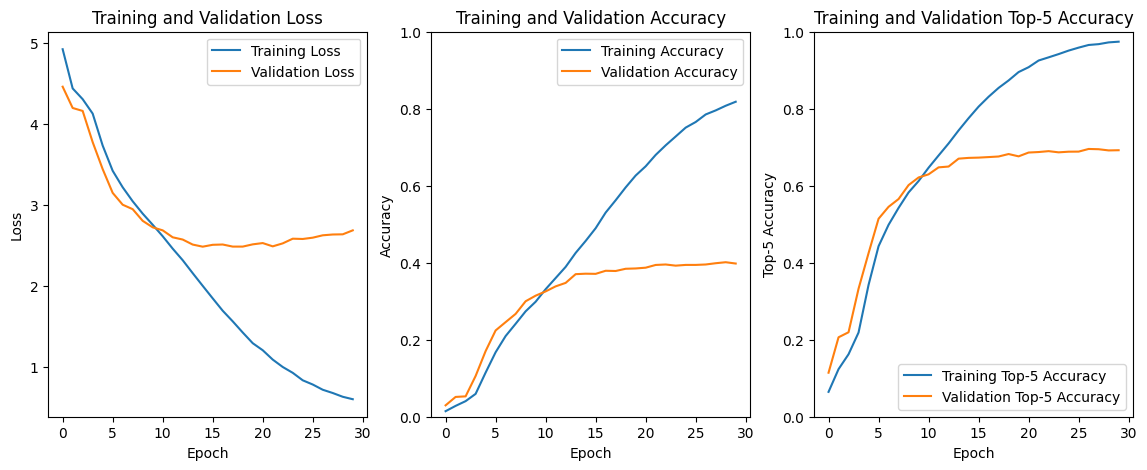

In [14]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['top-5-accuracy'], label='Training Top-5 Accuracy')
plt.plot(history.history['val_top-5-accuracy'], label='Validation Top-5 Accuracy')
plt.title('Training and Validation Top-5 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Top-5 Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [15]:
vit.evaluate(test_x, test_y)

313/313 [==============================] - 6s 20ms/step - loss: 2.6179 - accuracy: 0.4108 - top-5-accuracy: 0.6935


[2.617938280105591, 0.4108000099658966, 0.6934999823570251]